<a href="https://colab.research.google.com/github/Waidhoferj/CSC-566-Project/blob/PFLD/FacialLandmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Landmarks
Experimentation with facial landmarks models and datasets.

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from google.colab import drive
import os
from scipy.io import loadmat
import random

In [96]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Add your name and filepath to the project folder so that you can load the datasets.


In [97]:
USER = "John"
USER_FILEPATHS = {
    "John" : "/content/drive/MyDrive/CSC 566 Project",
    "Jeremy" : "/content/drive/MyDrive/School/Undergrad/2021 Spring/CSC 566/CSC 566 Project",
    "Ty" : "/content/drive/MyDrive/CSC 566 Project"
}
PROJECT_FILEPATH = USER_FILEPATHS[USER]
DATASETS_PATH = os.path.join(PROJECT_FILEPATH, "datasets", "300W-3D")

## Data Preparation

In [98]:
# Sanity check for loading data
def display_landmarks(img, points):
  """
  Displays portrait with landmark dots drawn on the face.
  Assumes that points are in (68,2)
  """
  #If we are reading from .mat files directly (2,68)
  if points.shape[0] == 2:
    points = points.transpose(1,0)
  #If reading from model output
  elif len(points.shape) == 1:
    points = points.reshape(-1,2)
  fig,ax = plt.subplots(1)
  ax.set_aspect('equal')
  ax.imshow(img)
  for p in points:
      circ = Circle(p)
      ax.add_patch(circ)
  plt.show()

#points = loadmat(AFW_DATASET + "/70037463_1.mat")["pt2d"]
#img  = plt.imread( AFW_DATASET+"/70037463_1.jpg")

#display_landmarks(img,points)



In [99]:
#Pose_Para 0-2 = pitch yaw roll
sources = ["IBUG"]
filepaths = [[os.path.join(DATASETS_PATH, source, file.split(".")[0]) for file in os.listdir(os.path.join(DATASETS_PATH, source)) if file.endswith(".mat")] for source in sources]

In [112]:
images = []
outputs = {"pose": [], "landmarks": []}
for path in filepaths[0][:50]:
  img = plt.imread(path + ".jpg")
  img = img.astype("float32") / 255.0
  images.append(img)
  mat = loadmat(path + ".mat")
  points = np.squeeze(mat["pt2d"].reshape((1, 136)))
  pose = mat["Pose_Para"][0][0:3]
  outputs["pose"].append(pose)
  outputs["landmarks"].append(points)

images = np.array(images).reshape((-1,450,450,3))
outputs["pose"] = (np.array(outputs["pose"]).reshape((-1,3)) + 1)/2
outputs["landmarks"] = np.array(outputs["landmarks"]).reshape((-1,136)) / 450

# def get_dataset_filenames(path):
#   return list(set([f"{path}/{name.split('.')[0]}" for name in os.listdir(path)]))

# # Using only IBUG and AFW is fine because of their size. If you add HELEN
# # with the current setup, it will take like 10 min to load and 3 min per epoch
# datasets = [
#             "IBUG", 
#             "AFW", 
#             "HELEN", 
#             # "LFPW"
#             ]
# filepaths = [get_dataset_filenames(f"{PROJECT_FILEPATH}/datasets/300W-3D/{ds}") for ds in datasets]
# filepaths = [item for sublist in filepaths for item in sublist] # Flattens the list

# Pair down based on batch size
#final_idx = len(filepaths) // BATCH_SIZE * BATCH_SIZE
#filepaths = np.array(filepaths[:final_idx])

#filepaths = filepaths.reshape((BATCH_SIZE, -1))

In [101]:
print(np.array(images).shape, np.array(outputs["landmarks"]).shape,np.array(outputs["pose"]).shape)

(50, 450, 450, 3) (50, 136) (50, 3)


## [PFLD Model](https://arxiv.org/pdf/1902.10859.pdf)


In [102]:

def relu6(x):
  return tf.clip_by_value(x, 0, 6)

def mobilenet_block(x:layers.Layer, t=2, c=64, s=2, name=None):
  """
  MoblieNetv2 residual block
  Arguments
  -----------
    x: keras layer input
    t: expansion factor based on size of input layer
    c: number of channels
    s: stride width/height
  """
  in_channels = x.shape[-1]
  l = layers.Conv2D(in_channels * t, (1,1), strides=(1,1), padding="same", name=name)(x) 
  l = layers.BatchNormalization(axis=-1, epsilon=1e-3,momentum=0.999,)(l)
  l = layers.Activation(relu6)(l)
  l = layers.DepthwiseConv2D((s,s), padding="same")(l)
  l = layers.BatchNormalization(axis=-1, epsilon=1e-3,momentum=0.999,)(l)
  l = layers.Activation(relu6)(l)
  l = layers.Conv2D(c, (1,1), strides=(1,1), padding="same")(l)
  l = layers.BatchNormalization(axis=-1, epsilon=1e-3,momentum=0.999,)(l)
  return layers.Add()([l,x])

def create_PFLD_model(input_shape, training=True):
  """
  Builds a backbone model that takes in an image and outputs 68 landmark locations.
  If training is true, it attaches the aux model
  """
  input_layer = layers.Input(input_shape, name="model_input")
  x = layers.Conv2D(64,(3,3), strides=(2,2), activation="relu")(input_layer)
  x = layers.DepthwiseConv2D(64, strides=(1,1), activation="relu")(x)
  for _ in range(5):
    x = mobilenet_block(x, t=2, c=64, s=2)
  aux_in = mobilenet_block(x, t=2, c=64, s=2) # TODO: c = 128 but theres an error so 64 for now
  aux_out = create_aux_model(aux_in)
  x = aux_in
  for _ in range(6):
    x = mobilenet_block(x, t=4, c=64, s=2)
  x = mobilenet_block(x, t=2, c=64, s=1) # c = 16 but ^



  x = layers.Conv2D(32,(3,3), strides=(2,2), activation="relu")(x)
  x = layers.Conv2D(32,(7,7), strides=(1,1), activation="relu")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(136, activation="relu", name="landmarks")(x)

  return Model(name="PFLM_Backbone", inputs=input_layer, outputs=[x, aux_out])
  
  


def create_aux_model(input_layer: layers.Layer):
  """
  Auxiliary model takes in the latent image representation from the MobileNet
  layers and produces an estimate of the pitch, yaw and roll of the face
  """

  x = input_layer
  x = layers.Conv2D(128, (3,3), strides=(2,2), activation="relu")(x)
  x = layers.Conv2D(128, (3,3), strides=(1,1), activation="relu")(x)
  x = layers.Conv2D(32, (3,3), strides=(2,2), activation="relu")(x)
  x = layers.Conv2D(128, (7,7), strides=(1,1), activation="relu")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(32, activation="relu")(x)
  return layers.Dense(3, activation="relu", name="pose")(x)






In [113]:
opt = tf.keras.optimizers.Adam()
model = create_PFLD_model((450,450,3))
model.compile(optimizer=opt, loss={"landmarks": "mse", "pose": "mse"}, metrics={"landmarks": tf.keras.metrics.RootMeanSquaredError(), "pose": tf.keras.metrics.RootMeanSquaredError()})

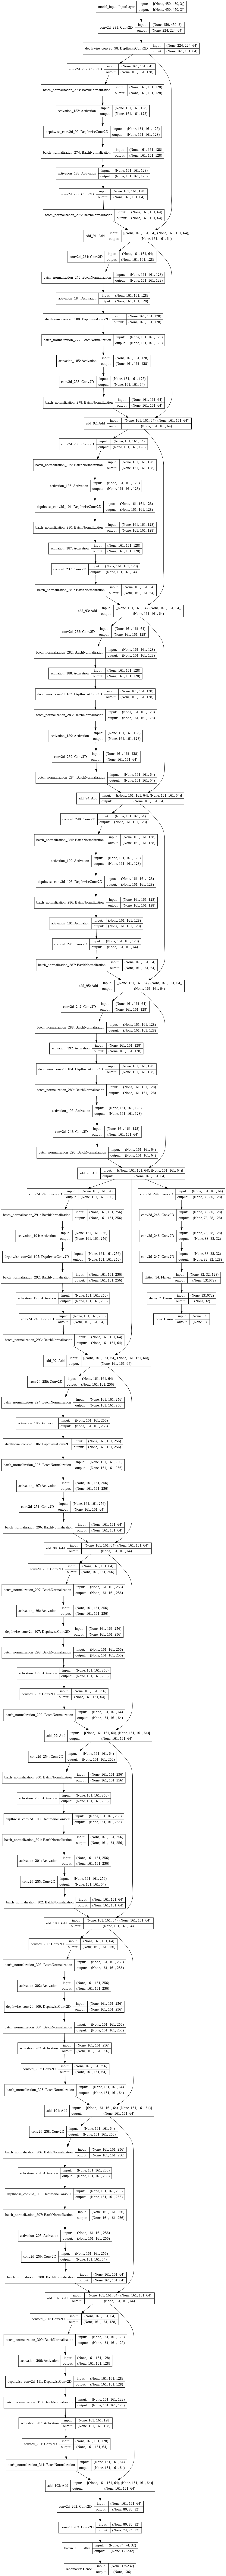

In [104]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [114]:
model.fit(x={"model_input":images}, y=outputs, epochs=50, batch_size=5)

Epoch 1/50
10/10 [==============================] - 17s 1s/step - loss: 19.0666 - landmarks_loss: 8.1755 - pose_loss: 10.8911 - landmarks_root_mean_squared_error: 2.8593 - pose_root_mean_squared_error: 3.3002
Epoch 2/50
10/10 [==============================] - 13s 1s/step - loss: 0.6190 - landmarks_loss: 0.3518 - pose_loss: 0.2672 - landmarks_root_mean_squared_error: 0.5931 - pose_root_mean_squared_error: 0.5169
Epoch 3/50
10/10 [==============================] - 13s 1s/step - loss: 0.6176 - landmarks_loss: 0.3504 - pose_loss: 0.2672 - landmarks_root_mean_squared_error: 0.5920 - pose_root_mean_squared_error: 0.5169
Epoch 4/50
10/10 [==============================] - 13s 1s/step - loss: 0.6158 - landmarks_loss: 0.3486 - pose_loss: 0.2672 - landmarks_root_mean_squared_error: 0.5904 - pose_root_mean_squared_error: 0.5169
Epoch 5/50
10/10 [==============================] - 13s 1s/step - loss: 0.6137 - landmarks_loss: 0.3466 - pose_loss: 0.2672 - landmarks_root_mean_squared_error: 0.5887 - 

In [117]:
# pd.DataFrame(model.history.history).plot()
landmarks, poses = model.predict(images)
landmarks = (landmarks + 1) *450/2

In [118]:
landmarks[2] - landmarks[5]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

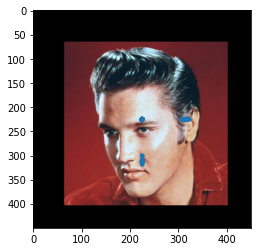

In [120]:
#@title View Predicted Images
image_index = 4 #@param {type:"slider", min:1, max:16, step:1}
points = predictions * 450
i = 0
for x in images:
  if (i == image_index):
    display_landmarks(tf.reshape(x, (450,450,3)), landmarks[image_index])
    break
  i += 1

## Basic Benchmark Model
From [this medium article](https://towardsdatascience.com/detecting-facial-features-using-deep-learning-2e23c8660a7a)

In [ ]:
def create_basic_landmark_model(input_shape, conv_range):
  input_layer = layers.Input(input_shape)
  x = input_layer
  for exp in conv_range:
    x = layers.Conv2D(2**exp, (3,3), 3, activation="relu")(x)
    x = layers.MaxPool2D(padding="same")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(500, activation="relu")(x)
  x = layers.Dense(90, activation="relu")(x)
  x = layers.Dense(68*2, activation="relu")(x)
  return Model(name="landmark_locator", inputs=input_layer, outputs=x)



In [ ]:
INPUT_SHAPE = (450,450,3)
basic_model = create_basic_landmark_model(INPUT_SHAPE, range(5,8))
basic_model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
basic_model.summary()

Model: "landmark_locator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 450, 450, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)    

In [ ]:
basic_model.fit(train_data.shuffle(64), epochs=30, validation_data=val_data, verbose=1)

### Analyze Results

In [ ]:
pd.DataFrame(basic_model.history.history).plot()

In [ ]:
predictions = basic_model.predict(test_data.map(lambda x,y: x))

In [ ]:
#@title View Predicted Images
image_index = 3 #@param {type:"slider", min:1, max:16, step:1}
points = predictions * 450
i = 0
for x in test_data.map(lambda x,y: x):
  if (i == image_index):
    display_landmarks(tf.reshape(x, DataLoader.IMAGE_SHAPE), points[image_index])
    break
  i += 1